<a href="https://colab.research.google.com/github/Programmer484/Tic-Tac-Toe-Neural-Network/blob/main/Tic_Tac_Toe_NN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hey! If you're looking for a fun interactive way to get into machine learning, you're in the right place!** 😀

Today, we'll be applying reinforcement learning to train an AI that can play tic-tac-toe on various board sizes! For example, 3 in a row on a 3x3 board (regular), 4 in a row on 6x6 board, etc.

### Demo

First off, let's start off with a sneak peek at what we'll be building throughout this tutorial 👀

Instructions:

1. Run the cell called "final code". It contains all the functions that will be used in training and playing.
2. Train the neural network
3. Play against it!


#### Final code

In [ ]:
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.set_printoptions(sci_mode=False, linewidth=120)

def position_to_tensor(board, net):
    device = "cuda" if next(net.parameters()).is_cuda else "cpu"
    position = torch.Tensor(board.state) * board.turn
    position = position.unsqueeze(0).to(device)
    return position

"""Network"""
class Net(nn.Module):
    def __init__(self, width, height):
        super().__init__()
        self.width = width
        self.height = height
        # common layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # action policy layers
        self.act_conv1 = nn.Conv2d(128, 4, kernel_size=1)
        self.act_fc1 = nn.Linear(4*width*height,
                         width*height)
        # value prediction layers
        self.val_conv1 = nn.Conv2d(128, 2, kernel_size=1)
        self.val_fc1 = nn.Linear(2*width*height, 64)
        self.val_fc2 = nn.Linear(64, 1)

    def forward(self, net_input):
        # common layers
        x = F.relu(self.conv1(net_input))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # action policy layers
        x_act = F.relu(self.act_conv1(x))
        x_act = x_act.view(-1, 4*self.width*self.height)
        x_act = F.softmax(self.act_fc1(x_act), dim=1)
        x_act = x_act.view(-1, self.width, self.height)
        # value prediction layers
        x_val = F.relu(self.val_conv1(x))
        x_val = x_val.view(-1, 2*self.width*self.height)
        x_val = F.relu(self.val_fc1(x_val))
        x_val = torch.tanh(self.val_fc2(x_val))
        return x_act, x_val

"""Board"""
class Board:
    def __init__(self, width, height, win_length, turn, state=None, empties=None):
        self.width = width
        self.height = height
        self.win_length = win_length
        self.turn = float(turn)
        if state == None:
            self.state = tuple([0.0 for _ in range (width)] for _ in range(height))
            self.empties = [(x, y) for y in range (height) for x in range(width)]
        else:
            self.state = tuple([x for x in y] for y in state)
            self.empties = [e for e in empties]
    def __str__(self):
        board_state_as_str = ""
        board_state = [row.copy() for row in self.state]
        for row in board_state:
            for i, token in enumerate(row):
                if token == 1.0:
                    row[i] = "X"
                elif token == -1.0:
                    row[i] = "O"
                elif token == 0.0:
                    row[i] = "_"
            board_state_as_str += str(row) + "\n"
        return board_state_as_str
    def deepcopy(self):
        board = Board(self.width, self.height, self.win_length, self.turn, self.state, self.empties)
        return board
    def out_of_bounds(self, square, max_x, max_y):
        return (square[0] < 0 or square[1] < 0 or square[0] >= max_x or square[1] >= max_y)
    def outcome(self, updated_square):
        player_num = self.state[updated_square[1]][updated_square[0]]
        vectors = []
        for x in [-1, 0, 1]:
            for y in [-1, 0, 1]:
                if x == 0 and y == 0:
                    continue
                # if a neighbouring square is out of bounds, skip to the next coordinate
                if updated_square[0] - 1 < 0 and x == -1:  # past left edge
                    continue
                if updated_square[0] + 1 > self.width - 1 and x == 1:  # past right edge
                    continue
                if updated_square[1] - 1 < 0 and y == -1:  # past top edge
                    continue
                if updated_square[1] + 1 > self.height - 1 and y == 1:  # past bottom edge
                    continue
                neighbour_x, neighbour_y = updated_square[0] + x, updated_square[1] + y
                if self.state[neighbour_y][neighbour_x] == player_num:
                    vector = (neighbour_x - updated_square[0], neighbour_y - updated_square[1])
                    if vector not in [(v[0]*-1, v[1]*-1) for v in vectors]: # if there is not already a vector in the opposite direction
                        vectors.append(vector)
        for vector in vectors:
            line_length = 1
            reversing = False
            i = 1
            # Keep checking adjacent squares in one direction and increase the row length by 1 whenever the token matches the token just placed
            # When an edge, empty space, or opponent token is encountered, count squares in the opposite direction skipping over all the ones we already counted
            while i < self.win_length:
                if not reversing:
                    x = updated_square[0] + i * vector[0]
                    y = updated_square[1] + i * vector[1]
                    next_square = x, y
                else:
                    x = updated_square[0] + i * -vector[0]
                    y = updated_square[1] + i * -vector[1]
                    next_square = x, y

                if self.out_of_bounds(next_square, self.width, self.height) \
                or self.state[next_square[1]][next_square[0]] != player_num:
                    if not reversing:
                        reversing = True
                        i = 0
                    else:
                        break
                else:
                    line_length += 1
                    if line_length >= self.win_length:
                        return player_num
                i += 1
        if len(self.empties) == 0:
            return 0.0
        return None
    def make_move(self, move_coords: tuple):
        self.empties.remove(move_coords)
        self.state[move_coords[1]][move_coords[0]] = self.turn
        self.turn *= -1.0


"""MCTS"""
class Node:
    def __init__(self, parent, prob, board, move):
        self.parent = parent
        self.children = []
        self.visit_count = 0
        self.total_value = 0
        self.value = 0
        self.prob = prob
        self.board = board
        self.move = move

    def is_terminal(self):
        return self.board.outcome(self.move) != None

    def is_leaf(self):
        return self.children == []
class MCTS:
    """Search function always evaluates the best move for the 1s player"""
    def __init__(self, board, net):
        self.net = net
        self.root_node = Node(None, None, board, (-2, -2))
        self.c_puct = 1.0
        self.tau = 1.0
    def uct(self, parent, node):
        return self.c_puct * node.prob * (math.sqrt(parent.visit_count)/(1 + node.visit_count))

    def select(self, node):
        if node.is_leaf():
            return node
        else:
            max_value = -500000
            chosen_node = None
            for child_node in node.children:
                uct_val = self.uct(node, child_node)
                q_val = child_node.value * node.board.turn
                value = q_val + uct_val
                if value > max_value:
                    max_value = value
                    chosen_node = child_node
            return self.select(chosen_node)
    def expand_to_backprop(self, node):
        position_as_tensor = position_to_tensor(node.board, self.net)
        net_output = self.net(position_as_tensor)
        legal_moves = node.board.empties
        legal_moves_prob_sum = 0.0
        for m in legal_moves:
            child_prob = net_output[0][0][m[1], m[0]].item()
            legal_moves_prob_sum += child_prob
        for m in legal_moves:
            child_board = node.board.deepcopy()
            child_board.make_move(m)
            child_prob = net_output[0][0][m[1], m[0]].item()/legal_moves_prob_sum
            child_node = Node(node, child_prob, child_board, m)
            node.children.append(child_node)
        evaluation = net_output[1][0].item() * node.board.turn
        self.backpropagate(node, evaluation)

    def backpropagate(self, node, evaluation):
        node.visit_count += 1
        node.total_value += evaluation
        node.value = node.total_value / node.visit_count
        if node.parent != None:
            self.backpropagate(node.parent, evaluation)

    def search(self, reps):
        torch.set_grad_enabled(False)
        for _ in range(reps):
            node = self.select(self.root_node)
            if node.is_terminal():
                self.backpropagate(node, node.board.outcome(node.move))
            else:
                self.expand_to_backprop(node)
        move_probs = []
        for child_node in self.root_node.children:
            prob = round(child_node.visit_count ** (1/self.tau) / (self.root_node.visit_count ** (1/self.tau)), 3)
            move_probs.append((child_node.move, prob))
        return move_probs
"""Reinforcement learning"""
class RL:
    def __init__(self, net, width, height, win_length):
        self.net = net
        self.width = width
        self.height = height
        self.win_length = win_length

    def self_play_game(self, mcts_reps):
        positions_data = []
        move_probs_data = []
        values_data = []
        game_on = True
        board = Board(self.width, self.height, self.win_length, 1)
        while game_on:
            position_as_tensor = position_to_tensor(board, self.net)
            positions_data.append(position_as_tensor)
            values_data.append(torch.Tensor([board.turn]))
            mcts_searcher = MCTS(board, self.net)
            mcts_move_probs = mcts_searcher.search(mcts_reps)
            move_probs_matrix = [[0.0] * self.width for y in range(self.height)]  # for the network
            moves = [] # for making a move
            move_probs = [] # for making a move
            for move, prob in mcts_move_probs:
                move_probs_matrix[move[1]][move[0]] = prob
                moves.append(move)
                move_probs.append(prob)
            move_probs_matrix = torch.Tensor(move_probs_matrix)
            move_probs_data.append(move_probs_matrix)
            selected_idx = np.random.multinomial(1, move_probs)
            chosen_move = moves[np.where(selected_idx==1)[0][0]]
            board.make_move(chosen_move)
            value = board.outcome(chosen_move)
            if value != None:
                for i in range(len(positions_data)):
                    values_data[i] *= value
                return (positions_data, move_probs_data, values_data)
"""Dataloader"""
class GomokuDataset(Dataset):
    def __init__(self, games):
        super().__init__()
        self.games = games
    def __len__(self):
        return len(self.games[0])
    def __getitem__(self, index):
        return self.games[0][index], self.games[1][index], self.games[2][index]

"""Play games"""
def net_choose_move(board, net):
    torch.set_grad_enabled(False)
    position_as_tensor = position_to_tensor(board, net)
    move_probs = net(position_as_tensor)[0][0]
    vals = []
    total_val = 0
    for square in board.empties:
        total_val += (move_probs[square[1], square[0]]) ** 1
    for square in board.empties:
        val = move_probs[square[1], square[0]].to("cpu")
        vals.append(math.floor(val ** 1/total_val * 5000)/5000)
    selected_idx = np.random.multinomial(1, vals)
    chosen_move = board.empties[np.where(selected_idx==1)[0][0]]
    return chosen_move


def mcts_net_vs_human(board, mcts_reps, net):
    game_on = True
    while game_on:
        if board.turn == 1:
            print(f"======= X player's turn to move =======")
            if mcts_reps > 0:
                mcts_searcher = MCTS(board, net)
                mcts_move_probs = mcts_searcher.search(mcts_reps)
                chosen_move = max(mcts_move_probs, key=lambda x: x[1])[0]
            else:
                chosen_move = net_choose_move(board, net)
                position_as_tensor = position_to_tensor(board, net)
                net_output = net(position_as_tensor)
                print(f"Move probabilities: \n{net_output[0][0]}\n")
                print(f"Outcome prediction: \n{net_output[1][0]}\n")
            board.make_move(chosen_move)
        else:
            print(f"======= O player's turn to move =======")
            try:
                x = input("x: ")
                y = input("y: ")
                chosen_move = (int(x), int(y))
                board.make_move(chosen_move)
            except Exception:
                print("Invalid move, please try again")
                continue

        print("Board:")
        print(board)
        value = board.outcome(chosen_move)
        if value != None:
            break


def net_vs_net(start_board, net1, net2, games):
    win_count = [0, 0]
    for game in range(games):
        if game % 2 == 0:
            nets = (net1, net2)
            first_net_idx = 0
            second_net_idx = 1
        else:
            nets = (net2, net1)
            first_net_idx = 1
            second_net_idx = 0
        board = start_board.deepcopy()
        game_on = True
        net_outputs = []
        while game_on:
            if board.turn == 1.0:
                net = nets[0]
            else:
                net = nets[1]

            chosen_move = net_choose_move(board, net)

            # mcts_searcher = MCTS(board, net)
            # mcts_move_probs = mcts_searcher.search(200)
            # chosen_move = max(mcts_move_probs, key=lambda x: x[1])[0]

            # move_probs_matrix = [[0.0] * board.width for y in range(board.height)]  # for the network
            # for move, prob in mcts_move_probs:
            #     move_probs_matrix[move[1]][move[0]] = prob
            # move_probs_matrix = torch.Tensor(move_probs_matrix)
            # position_as_tensor = position_to_tensor(board, net)
            # net_output = net(position_as_tensor)
            # net_outputs.extend((move_probs_matrix, net_output[1][0], chosen_move))

            board.make_move(chosen_move)
            value = board.outcome(chosen_move)

            if value != None:
                if value == 1.0:
                    win_count[first_net_idx] += 1
                elif value == -1.0:
                    win_count[second_net_idx] += 1
                game_on = False
    return win_count

"""Train"""
def train(main_net, opponent_net, learner, generations, games_per_generation, training_epochs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    main_net = main_net.to(device)
    opponent_net = opponent_net.to(device)
    for generation in range(1, generations):
        # game generation
        all_positions = []
        all_move_probs = []
        all_values = []
        st = time.perf_counter()
        for game in range(games_per_generation):
            positions, move_probs, values = learner.self_play_game(200)
            all_positions += positions
            all_move_probs += move_probs
            all_values += values
        et = time.perf_counter()
        print(f"===== Game generation time in seconds: {et-st} ======")
        all_games = (all_positions, all_move_probs, all_values)
        # data preparation
        train_data = GomokuDataset(all_games)
        train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)
        # training
        torch.set_grad_enabled(True)
        policy_loss_metric = nn.BCELoss()
        value_loss_metric = nn.MSELoss()
        optimizer = torch.optim.Adam(main_net.parameters(), lr=0.003, weight_decay=1e-4)
        for epoch in range(training_epochs):
            running_loss = 0
            for position, move_probs, value in train_data_loader:
                position, move_probs, value = position.to(device), move_probs.to(device), value.to(device)
                output = main_net(position)
                policy_loss = policy_loss_metric(output[0], move_probs)
                value_loss = value_loss_metric(output[1], value)
                loss = policy_loss + value_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Training loss: {running_loss/len(train_data_loader)}")
        # evaluating model
        win_counts = net_vs_net(Board(3, 3, 3, 1), main_net, opponent_net, 1000)
        print("")
        print(f"main_net wins: {win_counts[0]}")
        print(f"main_net losses: {win_counts[1]}")
        print(f"main_net draws: {1000 - win_counts[0] - win_counts[1]}")
        if win_counts[0] - win_counts[1] > 150:
            torch.save(main_net.state_dict(), f"model_{generation}.pt")
            opponent_net.load_state_dict(torch.load(f"model_{generation}.pt"))
            print(f"Saved model {generation}")
            print(f"Updated opponent_net to copy of main_net")



main_net = Net(3, 3)
# main_net.load_state_dict(torch.load("model.pt"))
opponent_net = Net(3, 3)
learner = RL(main_net, 3, 3, 3)

#### Train the network

Feel free to experiment with the last three parameters which are: # network generations, # games generated per generation, and # training epochs per generation

In [ ]:
train(main_net, opponent_net, learner, 5, 80, 15)

#### Play against the network!

The outputs will be:

1. The board
2. The network's move policy as a grid
3. The network's prediction of who will win
  * &nbsp;1.00 = 100% confident Xs win
  * -1.00 = 100% confident Os win
  * &nbsp;0.00 = 100% confident of a tie


* The top left square is (0, 0)
* Input the x-coordinate of your desired square, press enter, then input the y-coordinate.

In [ ]:
board = Board(3, 3, 3, 1)  # -1 means you go first, 1 means network goes first
mcts_net_vs_human(board, 0, main_net)

### Intro

<a name="intro"></a>
Well, wasn't that fun!

I know you're excited to begin coding, but make sure you have a rough understanding of **Python** and **neural networks** before we begin. If not, there are some resources below.

Just make sure you DON'T GO DOWN A YOUTUBE/WEB SURFING RABBIT HOLE!! Set yourself a loud timer — at least as loud as an atomic bomb going off next to you — for however long you intend to learn/research. Then get back here as soon as it goes off!

1. Python
  * If you already have programming knowledge: just look up keywords as you go. Personally I recommend w3schools.
  * If you have never coded before: check out one of the two resources here. The key is to learning is to DO THE EXERCISES!!
    * https://nostarch.com/download/Python_for_Kids_Solutions__Briggs.pdf
      * It doesn't matter whether you are a kid or an adult. The explanations are very intuitive.

    * https://automatetheboringstuff.com/#toc
      * Go up to chapter 6

2. How a neural network works
  * [Videos + Interactive Demo](https://www.3blue1brown.com/lessons/neural-networks)
    * Go up to chapter 4
    * ~20 min / chapter
  * [Article](https://ryan-leong.medium.com/the-basics-of-neural-networks-for-chess-nerds-and-anyone-interested-in-ai-e76e03124867)
    * Refresher for if you've already learned about NNs in the past
    * ~15 min
  * I recommend understanding neural networks before we start building, but if you are reaaaaally so excited to start coding, then
    * **think of a neural network as a toddler who learns as they are repeatedly shown what to do (output) in a given situation (input)**. For example, be quiet when the parents are sleeping, but be loud when only their siblings are sleeping. When they do the wrong thing, we ~give them a whack on the butt~ show them how they can adjust their actions to get better.
    * If you want something closer to what an actual neural network is, then think of the network as a very complex mathematical function with many constants and terms. Whenever we train the network, we are making adjustments to these constants so the function better maps our input to our desired output.



**IMPORTANT!** Whenever you see this:

🛑 + 🧠

It means you should pause and think about the prompt for 1+ minutes. Take as long as you need.

In fact, right now I want you to grab a piece of paper, or open a plaintext file so you can write/type your thoughts there as you think.

This is **where the learning happens!**

### The plan

Basically what we're going to do, is show our neural network a bunch of positions and teach it what the best move is in each position.

As it learns what the best move in various positions are, the network will eventually learn to recognize patterns, like the fact that it should always take an opportunity to place a token that forms 3 in a row, leading to victory.

Any questions?

🛑 + 🧠

Hopefully most of your questions will be answered throughout the tutorial, but the most pressing ones would be:

1. Where are we going to get these positions and best moves from?

Let's think about this one together. Paper/text file time!

🛑 + 🧠

The first option would be to use a database of tic-tac-toe games that also includes the best move for each position in each game. Using this approach would be considered supervised learning.

We might be able to find a database for typical tic-tac-toe on a 3x3 board, but if we want to train our network to on different board sizes and win_lengths, we're going to have to **generate our own database**.

To accomplish this, first we generate games by getting an AI or algorithm to play lots of games against itself. Then, we'll need to run an **algorithm** on each position in each game **which returns the best move**. The data generated should be formatted in the same way as database we'd use for supervised learning, with several pairings of a positions + the best move.

Of course you might be thinking, but what if we were trying to use reinforcement learning on a game that we _don't_ have a good known algorithm for finding the best move? Don't worry, there's an algorithm works for **any game**. Whoaaaaa😯

#### Recap

In short, we're going to repeat the following two steps until network reaches its desired strength:
  - Generate games through self-play
  - Train the network with these generated games

Let's begin！🏁

### Generating games through self-play

Try writing down all the steps/parts of how we can generate a database of positions and their best moves when we don't already have one.

No peeking at the previous cell!🙈

🛑 + 🧠

Done? Hopefully you included at least two of these three steps:
1. The game engine, which allows us to track the tokens on the board and check when one player has won
2. An AI or algorithm to choose moves for both sides
3. An algorithm which returns the best move for each position

But first, let's build the game engine!

#### Game engine

The game engine is actually a great thing to try coding yourself :)

Two things I STRONGLY recommend for all coding exercises going forwards:

1. Copy and paste exercise code into a code editor like replit or VS code
  - Far **superior debugging abilities**. Search up "replit debugger" if you've never used breakpoints in replit
  - You won't have to search for code cells in Google colab if you don't finish the tutorial in one session.
2. Turn off code generation/suggestion
  - I think it takes away a lot of the thinking that's so crucial to learning something new.

I've added some checkpoints to help guide you below. The internet is your friend when you get stuck.

Well, a treacherous friend because sometimes it will betray you by leading you down a useless rabbit hole. Just stay intentional 😉

Stage 1: Create a class that keeps track of the game state and allows you to place tokens with a move method

In [ ]:
# Exercise
class Board:
    def __init__(self, state):
        self.state = state

    def make_move(self, move):
        pass

    def outcome(self):  # This function is for later
        pass

# Let's use 0s for empty spaces, and -1s and 1s to represent the two players.
# Using numbers instead of strings will be helpful when we later need to feed our board position to a neural network
start_state = [[-1,  0,  0],
               [ 0,  0,  0],
               [ 0,  0,  1]]

board = Board(start_state)

board.make_move((1, 1))
print(board.state)

board.make_move((1, 1))  # This should throw an error since the space is already occupied


# Expected outcomes
after_move1 = [[-1,  0,  0],
               [ 0,  1,  0],
               [ 0,  0,  1]]
after_move2 = "Space already occupied, please don't sit on other people."

Stage 2: Alternate between placing 1s and -1s depending on whose turn it is.

In [ ]:
# Exercise
# Replace this line with your Board class from the previous cell

start_state = [[1, -1,  1],
               [0,  0,  0],
               [0,  0, -1]]

board = Board(start_state)

board.make_move((0, 0))
print(board.state)

board.make_move((2, 2))
print(board.state)

board.make_move((1, 1))
print(board.state)


# Expected outcomes
after_move1 = [[1,  0,  0],
               [0,  0,  0],
               [0,  0,  0]]

after_move2 = [[1,  0,  0],
               [0,  0,  0],
               [0,  0, -1]]

after_move3 = [[1,  0,  1],
               [0,  0,  0],
               [0,  0, -1]]

Stage 3: Check if the game has ended and return the outcome

In [ ]:
# Exercise
# Replace this line with your Board class from the previous cell

start_state1 = [[ 1,  0, -1],
                [ 0,  1, -1],
                [ 0,  0,  1]]

start_state2 = [[-1,  0,  1],
                [-1,  1,  0],
                [-1,  0,  0]]

start_state3 = [[ 1,  1, -1],
                [-1, -1,  1],
                [ 1, -1,  1]]

start_state4 = [[ 0,  0,  0],
                [-1,  1,  1],
                [ 0, -1,  0]]

board1 = Board(start_state1)
board1.outcome()  # should return  1 for  1s player wins

board2 = Board(start_state2)
board2.outcome()  # should return -1 for -1s player wins

board3 = Board(start_state3)
board3.outcome()  # should return  0 for draw

board4 = Board(start_state4)
board4.outcome()  # should return None since the game is not over

Congrats! You've finished coding the game engine!

If you want, you can use your own Board class code going forwards, but I've made a few additional changes to the Board class after actually using it with the rest of tic-tac-toe code.

The main changes are an optimized deepcopy function and outcome check function for much faster computation.

I'd strongly suggest using the following code going forward just to avoid future bugs/compatability issues with the rest of the tutorial, but remember that you've already done the learning by coding a version of the Board class yourself :)

Make sure to paste this at the top of your code editor so you have access to the Board class for the rest of the tutorial! Or run the cell if you are using Google colab.


##### Final Board code

In [ ]:
# Solution
class Board:
    def __init__(self, width, height, win_length, turn, state=None, empties=None):
        self.width = width
        self.height = height
        self.win_length = win_length
        self.turn = float(turn)
        if state == None:
            self.state = tuple([0.0 for _ in range (width)] for _ in range(height))
            self.empties = [(x, y) for y in range (height) for x in range(width)]
        else:
            self.state = tuple([x for x in y] for y in state)
            self.empties = [e for e in empties]
    def __str__(self):
        board_state_as_str = ""
        board_state = [row.copy() for row in self.state]
        for row in board_state:
            for i, token in enumerate(row):
                if token == 1.0:
                    row[i] = "X"
                elif token == -1.0:
                    row[i] = "O"
                elif token == 0.0:
                    row[i] = "_"
            board_state_as_str += str(row) + "\n"
        return board_state_as_str
    def deepcopy(self):
        board = Board(self.width, self.height, self.win_length, self.turn, self.state, self.empties)
        return board
    def out_of_bounds(self, square, max_x, max_y):
        return (square[0] < 0 or square[1] < 0 or square[0] >= max_x or square[1] >= max_y)
    def outcome(self, updated_square):
        player_num = self.state[updated_square[1]][updated_square[0]]
        vectors = []
        for x in [-1, 0, 1]:
            for y in [-1, 0, 1]:
                if x == 0 and y == 0:
                    continue
                # if a neighbouring square is out of bounds, skip to the next coordinate
                if updated_square[0] - 1 < 0 and x == -1:  # past left edge
                    continue
                if updated_square[0] + 1 > self.width - 1 and x == 1:  # past right edge
                    continue
                if updated_square[1] - 1 < 0 and y == -1:  # past top edge
                    continue
                if updated_square[1] + 1 > self.height - 1 and y == 1:  # past bottom edge
                    continue
                neighbour_x, neighbour_y = updated_square[0] + x, updated_square[1] + y
                if self.state[neighbour_y][neighbour_x] == player_num:
                    vector = (neighbour_x - updated_square[0], neighbour_y - updated_square[1])
                    if vector not in [(v[0]*-1, v[1]*-1) for v in vectors]: # if there is not already a vector in the opposite direction
                        vectors.append(vector)
        for vector in vectors:
            line_length = 1
            reversing = False
            i = 1
            # Keep checking adjacent squares in one direction and increase the row length by 1 whenever the token matches the token just placed
            # When an edge, empty space, or opponent token is encountered, count squares in the opposite direction skipping over all the ones we already counted
            while i < self.win_length:
                if not reversing:
                    x = updated_square[0] + i * vector[0]
                    y = updated_square[1] + i * vector[1]
                    next_square = x, y
                else:
                    x = updated_square[0] + i * -vector[0]
                    y = updated_square[1] + i * -vector[1]
                    next_square = x, y

                if self.out_of_bounds(next_square, self.width, self.height) \
                or self.state[next_square[1]][next_square[0]] != player_num:
                    if not reversing:
                        reversing = True
                        i = 0
                    else:
                        break
                else:
                    line_length += 1
                    if line_length >= self.win_length:
                        return player_num
                i += 1
        if len(self.empties) == 0:
            return 0.0
        return None
    def make_move(self, move_coords: tuple):
        self.empties.remove(move_coords)
        self.state[move_coords[1]][move_coords[0]] = self.turn
        self.turn *= -1.0

#### Move chooser

When it comes to choosing moves, the question we have to ask ourselves is, what types of positions do we want our network to be trained on?

The more realistic ones of course. That means totally random moves would result in a lot of highly unlikely positions. Even if our best move algorithm always returns the best move in any position, our network won't be able to learn as much when there's a bunch of random tokens in positions where they'd never be in a real game.

So we need at least a semi intelligent algorithm or AI choosing the moves.

Hey, here's a thought. What if we just use the move recommended by the best move algorithm, since we're going to run it anyways? Yes let's try that!

#### Best move algorithm

So earlier I mentioned an AMAZING algorithm that can find the best move in any position for any game. Let's see if you can find it with the help of your friend the internet.

Just **set a 15 min timer** so you don't get sucked into the black hole of dog/cat pictures or whatever you fancy. Feel free to come back earlier if you think you found something :)

🛑 + 🧠

If you thought the existence of such an amazing algorithm was kinda
&nbsp;* sus *, you would make a good crewmate in Among Us ඞ.

Ahh, but I didn't lie. You see, this algorithm does find the best move... given enough _time_. I am speaking of the mighty Monte Carlo Tree Search (MCTS)! 🇲🇨 🌲 🔎

Okay jokes aside, MCTS still makes a good domain independent (doesn't matter which game) algorithm for finding good moves. Even if it can't find the best moves on larger boards or in more complex games, it will still act as a good guide.

So let's learn how to implement MCTS!

#### MCTS

I'd like to do this like we built the game engine, but this time with more guidance from me.

One major component of MCTS is about something known as random *playouts*. Keep in mind we'll start with **a very simplified version of MCTS** and introduce elements as we go, but I'll still call it MCTS.

Imagine there is a chess position where White has one move that captures Black's queen for free, and the rest of their moves don't. What MCTS does with random playouts is: for every single move White has in that position, it simulates a bunch of random continuations from that move until the game is over. Given enough simulations, we should find that the move where White captured their opponent's queen leads to an overall higher win rate compared to the moves where it didn't.

Let's try coding that for tic-tac-toe.

Make sure to run this ```grid_print``` function. We'll be using it in the rest of our MCTS exercises.

In [ ]:
def grid_print(grid, space=0, decimals=0, title=""):
    print(title)
    if grid != None:
      for row in grid:
          print("[", end="")
          for col in row:
              print(" ", end="")
              exec("""print("{:%s.%sf},".format(col), end=" ")""" % (space, decimals))
          print("]")
      print()
    else:
      print("No output\n")

Stage 1: Evaluating positions using random playouts

What we want our function to return is a score for each possible move. Ideally we want to have a score of -1 reflect 100% confidence in a win for the -1s player, and 1 reflect 100% confidence in a win for the 1s player.

I have given 3 inputs along with their expected outputs. Good luck!

In [ ]:
# Exercise
class MCTS:
    def __init__(self, board):
        self.board = board

    def search(self):
        for move in self.board.empties:
            pass  # return output as a 2D list

# Test cases
board1 = Board(3, 3, 3, 1)
board1.make_move((0, 0))
board1.make_move((1, 1))
board1.make_move((0, 1))
board1.make_move((0, 2))

board2 = Board(3, 3, 3, 1)
board2.make_move((0, 0))

board3 = Board(3, 3, 3, 1)
board3.make_move((0, 0))
board3.make_move((1, 1))
board3.make_move((2, 2))

# Your final scores should roughly resemble the scores in the grids below.
grid_print(board1.state, 2, 0, "Board 1")
mcts_searcher1 = MCTS(board1)
grid_print(mcts_searcher1.search(), 5, 2, "Value grid")
# [[0.00, -0.17,  0.17],
#  [0.00,  0.00, -0.83],
#  [0.00, -0.33, -0.50]]

grid_print(board2.state, 2, 0, "Board 2")
mcts_searcher2 = MCTS(board2)
grid_print(mcts_searcher2.search(), 5, 2, "Value grid")
# [[0.00, 0.45, 0.29],
#  [0.45, 0.12, 0.45],
#  [0.29, 0.45, 0.29]]

grid_print(board3.state, 2, 0, "Board 3")
mcts_searcher3 = MCTS(board3)
grid_print(mcts_searcher3.search(), 5, 2, "Value grid")
# [[ 0.00, -0.10, -0.17],
#  [-0.10,  0.00, -0.10],
#  [-0.17, -0.10,  0.00]]

Great work!

Short summary of my solution:
1. For each potential move, we first check if it immediately ends the game, and return the corresponding value (-1 for a -1s player win, 0 for a draw, and 1 for a 1s player win) if it does. Otherwise, we move on to simulating games to get an estimate for how good the move is.
2. In the ```simulate``` function, we play a set number of random games and take the average outcome of all the random games played to give us our final expected outcome.
3. The ```play_random_game``` function keeps making random moves for each side until the game ends. It returns a value of -1 for a -1s player win, 0 for a draw, and 1 for a 1s player win.

In [ ]:
# Solution
import torch
import random

class MCTS:
    def __init__(self, board):
        self.board = board

    def simulate(self, board, reps):
        total_value = 0
        for _ in range (reps):
            total_value += self.play_random_game(board.deepcopy())
        return total_value / reps

    def play_random_game(self, board):
        game_on = True
        while game_on:
            move = random.choice(board.empties)
            board.make_move(move)
            value = board.outcome(move)
            if value != None:
                return value

    def search(self):
        move_probability_grid = [[0.0 for x in range(3)] for y in range(3)]
        for move in self.board.empties:
            new_board = self.board.deepcopy()
            new_board.make_move(move)
            if new_board.outcome(move) != None:
                value = new_board.outcome(move)
            else:
                value = self.simulate(new_board, 5000)
            move_probability_grid[move[1]][move[0]] = value
        return move_probability_grid


# Test cases
board1 = Board(3, 3, 3, 1)
board1.make_move((0, 0))
board1.make_move((1, 1))
board1.make_move((0, 1))
board1.make_move((0, 2))

board2 = Board(3, 3, 3, 1)
board2.make_move((0, 0))

board3 = Board(3, 3, 3, 1)
board3.make_move((0, 0))
board3.make_move((1, 1))
board3.make_move((2, 2))

# Your final scores should roughly resemble the scores in the grids below.
grid_print(board1.state, 2, 0, "Board 1")
mcts_searcher1 = MCTS(board1)
grid_print(mcts_searcher1.search(), 5, 2, "Value grid")
# [[0.00, -0.17,  0.17],
#  [0.00,  0.00, -0.83],
#  [0.00, -0.33, -0.50]]

grid_print(board2.state, 2, 0, "Board 2")
mcts_searcher2 = MCTS(board2)
grid_print(mcts_searcher2.search(), 5, 2, "Value grid")
# [[0.00, 0.45, 0.29],
#  [0.45, 0.12, 0.45],
#  [0.29, 0.45, 0.29]]

grid_print(board3.state, 2, 0, "Board 3")
mcts_searcher3 = MCTS(board3)
grid_print(mcts_searcher3.search(), 5, 2, "Value grid")
# [[ 0.00, -0.10, -0.17],
#  [-0.10,  0.00, -0.10],
#  [-0.17, -0.10,  0.00]]


Stage 2: Converting scores into probabilities

All these negative and positives scores are rather difficult to interpret, since we have to remember which player's turn it is to move. Let's convert them into probabilities instead, where the highest probabilities are assigned to the **best moves for the player whose turn it is**.

In [ ]:
# Exercise
import torch
import random

class MCTS:
    def __init__(self, board):
        self.board = board

    def simulate(self, board, reps):
        total_value = 0
        for _ in range (reps):
            total_value += self.play_random_game(board.deepcopy())
        return total_value / reps

    def play_random_game(self, board):
        game_on = True
        while game_on:
            move = random.choice(board.empties)
            board.make_move(move)
            value = board.outcome(move)
            if value != None:
                return value

    def search(self):
        move_probability_grid = [[0.0 for x in range(3)] for y in range(3)]
        for move in self.board.empties:
            new_board = self.board.deepcopy()
            new_board.make_move(move)
            if new_board.outcome(move) != None:
                value = new_board.outcome(move)
            else:
                value = self.simulate(new_board, 5000)
            move_probability_grid[move[1]][move[0]] = value
        return move_probability_grid


# Test cases
board1 = Board(3, 3, 3, 1)
board1.make_move((0, 0))
board1.make_move((1, 1))
board1.make_move((0, 1))
board1.make_move((0, 2))

board2 = Board(3, 3, 3, 1)
board2.make_move((0, 0))

board3 = Board(3, 3, 3, 1)
board3.make_move((0, 0))
board3.make_move((1, 1))
board3.make_move((2, 2))

# Your final probabilities should roughly resemble the probabilities in the grids below
grid_print(board1.state, 2, 0, "Board 1")
mcts_searcher1 = MCTS(board1)
grid_print(mcts_searcher1.search(), 5, 2, "Value grid")
# [[0.00, 0.09, 0.87],
#  [0.00, 0.00, 0.00],
#  [0.00, 0.03, 0.01]]

grid_print(board2.state, 2, 0, "Board 2")
mcts_searcher2 = MCTS(board2)
grid_print(mcts_searcher2.search(), 5, 2, "Value grid")
# [[0.00, 0.05, 0.13],
#  [0.05, 0.41, 0.05],
#  [0.13, 0.05, 0.13]]

grid_print(board3.state, 2, 0, "Board 3")
mcts_searcher3 = MCTS(board3)
grid_print(mcts_searcher3.search(), 5, 2, "Value grid")
# [[0.00, 0.14, 0.22],
#  [0.14, 0.00, 0.14],
#  [0.22, 0.14, 0.00]]

Nice work!

Short summary of my solution:

1. I used a function from pytorch (softmax) which converts raw values into probabilities. It assigns higher values higher probabilities.

2. Since our MCTS function always assigns the most positive scores to the moves which it thinks will lead to the 1s player winning, whenever it was the -1s player's turn to move, I multiplied all the scores by -1, before applying the softmax function.




In [ ]:
# Solution
import random
import torch
import torch.nn.functional as F

class MCTS:
    def __init__(self, board):
        self.board = board

    def simulate(self, board, reps):
        total_value = 0
        for _ in range (reps):
            total_value += self.play_random_game(board.deepcopy())
        return total_value / reps

    def play_random_game(self, board):
        game_on = True
        while game_on:
            move = random.choice(board.empties)
            board.make_move(move)
            value = board.outcome(move)
            if value != None:
                return value

    def search(self):
        move_probs = []
        moves = []

        for move in self.board.empties:
            new_board = self.board.deepcopy()
            new_board.make_move(move)
            if new_board.outcome(move) != None:
                value = new_board.outcome(move)
            else:
                value = self.simulate(new_board, 5000)
            moves.append(move)
            move_probs.append(value)
        if self.board.turn == -1.0:
            move_probs = [-1.0 * x for x in move_probs]

        move_probs = F.softmax(torch.tensor(move_probs) * 7, dim=0)  # Convert legal moves to probabilities. Higher values get a higher probability. Multiplier of 7 is used to emphasize the difference between good moves and bad moves, otherwise the probabilities returned by softmax will all be too similar.
        move_probability_grid = [[0.0 for x in range(3)] for y in range(3)]
        for i, move in enumerate(moves):  # Fill in the move probability grid with the probabilities of legal moves, while leaving the occupied squares(aka illegal moves) with a probability of 0.0
            move_probability_grid[move[1]][move[0]] = move_probs[i]
        return move_probability_grid

# Test cases
board1 = Board(3, 3, 3, 1)
board1.make_move((0, 0))
board1.make_move((1, 1))
board1.make_move((0, 1))
board1.make_move((0, 2))

board2 = Board(3, 3, 3, 1)
board2.make_move((0, 0))

board3 = Board(3, 3, 3, 1)
board3.make_move((0, 0))
board3.make_move((1, 1))
board3.make_move((2, 2))

# Your final probabilities should roughly resemble the probabilities in the grids below
grid_print(board1.state, 2, 0, "Board 1")
mcts_searcher1 = MCTS(board1)
grid_print(mcts_searcher1.search(), 5, 2, "Value grid")
# [[0.00, 0.09, 0.87],
#  [0.00, 0.00, 0.00],
#  [0.00, 0.03, 0.01]]

grid_print(board2.state, 2, 0, "Board 2")
mcts_searcher2 = MCTS(board2)
grid_print(mcts_searcher2.search(), 5, 2, "Value grid")
# [[0.00, 0.05, 0.13],
#  [0.05, 0.41, 0.05],
#  [0.13, 0.05, 0.13]]

grid_print(board3.state, 2, 0, "Board 3")
mcts_searcher3 = MCTS(board3)
grid_print(mcts_searcher3.search(), 5, 2, "Value grid")
# [[0.00, 0.14, 0.22],
#  [0.14, 0.00, 0.14],
#  [0.22, 0.14, 0.00]]

After we run the cell, we can see our algorithm performs quite well in the first two examples.

In the 1st example, it is able to recognize the obvious opponent win threat and suggest a move to block it.

Furthermore, in the 2nd example it is even able to recognize that the best move is to play in the center (Any other move results in a loss with best play from both sides. You can verify this for yourself).

However, in the 3rd position, the top two moves recommended by the algoritm are actually the only two losing moves! What??!

Clearly a human would see if they placed a token in say, the top right corner at (2, 0) their opponent would naturally block them by placing on the bottom left corner at (0, 2) which gives them two win threats at the same time.
```python
[[1,  0, -1],
 [0, -1,  0],
 [1,  0,  1]]
```

This result doesn't change even with more simulations. Isn't MCTS supposed return the best move given enough time?

Yes! But what we have is only part of MCTS. Right now, our algorithm, doesn't account for the fact that most games have some level of intelligent moves on both sides. Like if the opponent sees a chance to complete 3 in a row, they will. Not place a token randomly.

Now how might we implement that?

🛑 + 🧠

If you like a good challenge, I encourage you to try creating your own move chooser function to replace the ```random.choice``` line in the ```play_random_game``` method of the MCTS class.
```python
def play_random_game(self, board):
    game_on = True
    while game_on:
        move = random.choice(board.empties)  # replace this line
        board.make_move(move)
        value = board.outcome(move)
        if value != None:
            return value

def choose_move(board):
    pass
```

One idea for choosing moves might be to query the neural network for moves. At first with an untrained network, this is equivalent to playing random moves, but as we do training iterations the network will get better.

Ooh... that might work! Let's go with that.

So our best move algorithm will be a version of MCTS that evaluates moves with simulations of the neural network playing against itself.

Instead of ```move = random.choice(board.empties)```
, we'll use ```move = network(board.state)```
which is basically asking the network what move it would play in a given board state. Since our network hasn't been set up yet, we'll continue using ```random.choice``` as a placeholder for the rest of the game generation section.

Stage 3: Move selection

Now that we have a solid MCTS algorithm which returns a move probability grid, what we want is for the **probability of any specific move being played to correspond with its value in the probability grid**. For example, if our MCTS algorithm assigns a probability of 0.90 to a move_1 and 0.10 to move_2 in a given position, then move_1 should be played 90% of the time and move_2 should be played 10% of the time when that position arises.

I added a few extra lines to the MCTS search output to help get you started.

In [ ]:
# Exercise
import random
import torch
import torch.nn.functional as F

class MCTS:
    def __init__(self, board):
        self.board = board

    def simulate(self, board, reps):
        total_value = 0
        for _ in range (reps):
            total_value += self.play_random_game(board.deepcopy())
        return total_value / reps

    def play_random_game(self, board):
        game_on = True
        while game_on:
            move = random.choice(board.empties)
            board.make_move(move)
            value = board.outcome(move)
            if value != None:
                return value

    def search(self):
        move_probs = []
        moves = []

        for move in self.board.empties:
            new_board = self.board.deepcopy()
            new_board.make_move(move)
            if new_board.outcome(move) != None:
                value = new_board.outcome(move)
            else:
                value = self.simulate(new_board, 5000)
            moves.append(move)
            move_probs.append(value)
        if self.board.turn == -1.0:
            move_probs = [-1.0 * x for x in move_probs]
        move_probs = F.softmax(torch.tensor(move_probs) * 7, dim=0)  # Convert legal moves to probabilities. Higher values get a higher probability. Multiplier of 7 is used to emphasize the difference between good moves and bad moves, otherwise the probabilities returned by softmax will all be too similar.
        move_probability_grid = [[0.0 for x in range(3)] for y in range(3)]
        for i, move in enumerate(moves):  # Fill in the move probability grid with the probabilities of legal moves, while leaving the occupied squares(aka illegal moves) with a probability of 0.0
            move_probability_grid[move[1]][move[0]] = move_probs[i]
        return move_probability_grid

def select_move():
    pass


board1 = Board(3, 3, 3, 1)
board1.make_move((0, 0))
board1.make_move((1, 1))
board1.make_move((0, 1))
board1.make_move((0, 2))

mcts_searcher1 = MCTS(board1)
mcts_out = mcts_searcher1.search()
value_grid = [
[  0.00,   0.08,   0.88,],
[  0.00,   0.00,   0.00,],
[  0.00,   0.03,   0.01,]
]
grid_print(value_grid, 5, 2, "Value grid")

# Play a move using the move selection function and record how many times each move was played
move_counts = {}
reps = 1000
for i in range(reps):
    move = (0, 0)  # Replace this line
    if move in move_counts:
        move_counts[move] += 1
    else:
        move_counts[move] = 1

move_prob_grid = [[0.0 for x in range(3)] for y in range(3)]
for move in move_counts.keys():
    move_counts[move] /= reps
    move_prob_grid[move[1]][move[0]] = move_counts[move]

# The value grid should be nearly identical to the distribution of moves played
grid_print(move_prob_grid, 5, 2, "Distribution of moves played")

And that's the final part of our move chooser!

Short summary of my solution:
1. I altered the MCTS search function to return the moves and move probabilities along with the move grid. The indexes for ```moves``` and ```move_probs``` are aligned, meaning ```moves[0]``` returns the first move and ```move_probs[0]``` returns the probability assigned to that first move.
2. I used ```np.random.multinomial``` to selects a move from the ```move_probs``` list based on the probabilities.

Here's an example to clarify what ```np.random.multinomial``` does:
```python
moves_list = ["left", "right", "up"]
probabilities_list = [0.1, 0.2, 0.7]
selected_idx = np.random.multinomial(1, probabilities_list)
```

The first parameter of 1 tells us we only want to take 1 sample from ```probabilities_list```.

Then ```np.random.multinomial``` returns a list with the results of how many times each item in ```probabilities_list``` was chosen



When we draw only one sample:

10% of the time selected_idx will = ```[1, 0, 0]```

20% of the time selected_idx will = ```[0, 1, 0]```

70% of the time selected_idx will = ```[0, 0, 1]```

Then ```np.where(selected_idx==1)[0][0]``` tells us the index of the item with value = 1. Finally we use that index to access the corresponding move in ```moves_list```.



In [ ]:
# Solution
import random
import numpy as np
import torch
import torch.nn.functional as F

class MCTS:
    def __init__(self, board):
        self.board = board

    def simulate(self, board, reps):
        total_value = 0
        for _ in range (reps):
            total_value += self.play_random_game(board.deepcopy())
        return total_value / reps

    def play_random_game(self, board):
        game_on = True
        while game_on:
            move = random.choice(board.empties)
            board.make_move(move)
            value = board.outcome(move)
            if value != None:
                return value

    def search(self):
        move_probs = []
        moves = []

        for move in self.board.empties:
            new_board = self.board.deepcopy()
            new_board.make_move(move)
            if new_board.outcome(move) != None:
                value = new_board.outcome(move)
            else:
                value = self.simulate(new_board, 5000)
            moves.append(move)
            move_probs.append(value)
        if self.board.turn == -1.0:
            move_probs = [-1.0 * x for x in move_probs]
        move_probs = F.softmax(torch.tensor(move_probs) * 7, dim=0)  # Convert legal moves to probabilities. Higher values get a higher probability. Multiplier of 7 is used to emphasize the difference between good moves and bad moves, otherwise the probabilities returned by softmax will all be too similar.
        move_probs = move_probs.tolist()
        move_probability_grid = [[0.0 for x in range(3)] for y in range(3)]
        for i, move in enumerate(moves):  # Fill in the move probability grid with the probabilities of legal moves, while leaving the occupied squares(aka illegal moves) with a probability of 0.0
            move_probability_grid[move[1]][move[0]] = move_probs[i]
        return move_probability_grid, move_probs, moves

def select_move(move_probs, moves):
    selected_idx = np.random.multinomial(1, move_probs)
    return moves[np.where(selected_idx==1)[0][0]]


board1 = Board(3, 3, 3, 1)
board1.make_move((0, 0))
board1.make_move((1, 1))
board1.make_move((0, 1))
board1.make_move((0, 2))

mcts_searcher1 = MCTS(board1)
mcts_out = mcts_searcher1.search()
grid_print(mcts_out[0], 5, 2, "Value grid")

# Play a move using the move selection function and record how many times each move was played
move_counts = {}
reps = 1000
for i in range(reps):
    move = select_move(mcts_out[1], mcts_out[2])
    if move in move_counts:
        move_counts[move] += 1
    else:
        move_counts[move] = 1

move_prob_grid = [[0.0 for x in range(3)] for y in range(3)]
for move in move_counts.keys():
    move_counts[move] /= reps
    move_prob_grid[move[1]][move[0]] = move_counts[move]

# The value grid should be nearly identical to the distribution of moves played
grid_print(move_prob_grid, 5, 2, "Distribution of moves played")

#### Creating the game dataset

Now it's time to put together everything we did earlier!

What we want to do now, is create a function which simulates a bunch of games while adding the positions along with their best moves to a list.

A desired sample output would like something like this:

```python
[
  # First position + best_moves pair
  (
    # position
    [[0,  0,  0],
     [0, -1,  0],
     [0,  0,  0]],
    # move probabilities
    [[0.25, 0.00, 0.25],
     [0.00, 0.00, 0.00],
     [0.25, 0.00, 0.25]]
  ),
  # Second position + best_moves pair
  (
    # position
    [[ 0,  0,  1],
     [ 0, -1, -1],
     [ 0,  0,  0]],
    # move probabilities
    [[0.00, 0.00, 0.00],
     [1.00, 0.00, 0.00],
     [0.00, 0.00, 0.00]]
  )
  # And so on...
```
Keep in mind the move probabilities grids we actually get from MCTS won't always recommend the best moves so accurately like in the examples above.

I've pasted the latest board and mcts code below for convenience. The number of random playouts in MCTS has been greatly **reduced** so our game generation runs at a reasonable speed.

Make sure to copy and paste that right underneath the Board class at top of your code editor or run the cell if using Google Colab. The rest of the game generation code is all you!

##### Final MCTS code

In [ ]:
import random
import numpy as np
import torch
import torch.nn.functional as F


class MCTS:
    def __init__(self, board):
        self.board = board

    def simulate(self, board, reps):
        total_value = 0
        for _ in range (reps):
            total_value += self.play_random_game(board.deepcopy())
        return total_value / reps

    def play_random_game(self, board):
        game_on = True
        while game_on:
            move = random.choice(board.empties)
            board.make_move(move)
            value = board.outcome(move)
            if value != None:
                return value

    def search(self):
        move_probs = []
        moves = []

        for move in self.board.empties:
            new_board = self.board.deepcopy()
            new_board.make_move(move)
            if new_board.outcome(move) != None:
                value = new_board.outcome(move)
            else:
                value = self.simulate(new_board, 200)
            moves.append(move)
            move_probs.append(value)
        if self.board.turn == -1.0:
            move_probs = [-1.0 * x for x in move_probs]
        move_probs = F.softmax(torch.tensor(move_probs) * 7, dim=0)  # Convert legal moves to probabilities. Higher values get a higher probability. Multiplier of 7 is used to emphasize the difference between good moves and bad moves, otherwise the probabilities returned by softmax will all be too similar.
        move_probs = move_probs.tolist()
        move_probability_grid = [[0.0 for x in range(3)] for y in range(3)]
        for i, move in enumerate(moves):  # Fill in the move probability grid with the probabilities of legal moves, while leaving the occupied squares(aka illegal moves) with a probability of 0.0
            move_probability_grid[move[1]][move[0]] = move_probs[i]
        return move_probability_grid, move_probs, moves

def select_move(move_probs, moves):
    selected_idx = np.random.multinomial(1, move_probs)
    return moves[np.where(selected_idx==1)[0][0]]

##### Game generation code

In [ ]:
# Exercise
import pprint as pp

def generate_games(num_games):
    position_moveprob_pairs = []

    # To have the pairs printed nicely, make sure to use torch.tensor to convert your board.state and move probability grid
    # Example code shown below

    # pair = (torch.tensor(board.state), torch.tensor(mcts_out[0]))
    # position_moveprob_pairs.append(pair)

    return position_moveprob_pairs

position_moveprob_pairs = generate_games(1)
pp.pp(position_moveprob_pairs)

Woohoo! We can now generate games for our network to train on!

Short summary of my solution:
1. I used the MCTS search to return a move probability grid of the current position before making a move
2. I added the current position and move probability grid as a pair to our position + move probs database
3. I used our ```select_move``` function to determine which move to play based on the move probabilities in our move probability grid.

In [ ]:
# Solution
import pprint as pp

def generate_games(num_games):
    position_moveprob_pairs = []
    for _ in range(num_games):
        board = Board(3, 3, 3, 1)
        while True:
            mcts_searcher = MCTS(board)
            mcts_out = mcts_searcher.search()
            position_moveprob_pairs.append((torch.tensor(board.state), torch.tensor(mcts_out[0])))

            move = select_move(mcts_out[1], mcts_out[2])
            board.make_move(move)
            if board.outcome(move) != None:
                break
    return position_moveprob_pairs

position_moveprob_pairs = generate_games(3)
pp.pp(position_moveprob_pairs)

Now all we need is our neural network. We are almost there :D

### Building the network

Now would be a great time to go and learn about the inner workings of a neural network if you haven't already, otherwise it'll be quite difficult to follow along. [Jump to neural network resources](#intro).

Luckily, we don't have to build our network from scratch since developers before us built this handy library called pytorch. If you wanted to build your own neural networks from scratch, I'll link some resources at the end of the tutorial.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

When we build a network in pytorch, all we need to do is specify what types of layers we'll be using in the ```__init__``` function and how they are connected in the ```forward``` function.

Below is a example of a neural network that takes 1 input, has 2 neurons in its hidden layer, and has one output.

Each layer can be thought of as an object that stores the values of the weights and biases between neurons. So the two red rectangles would represent the two layers in our neural network. Neurons can be thought of as the connection points or joints between layers in a neural network.


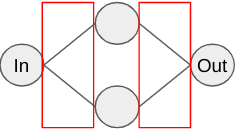

This cell shows how we would use code to create the neural network above.

In [ ]:
class ExampleNet(nn.Module): # inherit form pytorch's built in neural network class, nn.Module
    def __init__(self):
        # Defining the layers of our network
        super().__init__()
        self.fc1 = nn.Linear(1, 2)  # nn.Linear creates a fully connected layer
        self.fc2 = nn.Linear(2, 1)  # "fc" is a naming convention to indicate a fully connected layer

    def forward(self, net_input):
        # How are the layers connected to each other
        x = self.fc1(net_input)
        print(f"Hidden layer neuron outputs: {x}") #  Each item in the tensor corresponds to a hidden layer neuron's output
        x = F.relu(x) # Applies relu activation function to each hidden layer neuron
        print(f"Hidden layer neuron outputs after relu: {x}")
        x = self.fc2(x)
        print(f"Final network output: {x}")

        return x

net_in = torch.tensor([1.0])
net = ExampleNet()
net_out = net(net_in)


Of course, these numbers and dimensions don't really mean much.

Let's try building a network that takes in a 3x3 board and outputs a 3x3 move probability grid.

Here are some things to note:
- Fully connected layers only take 1 dimensional inputs, so assume our board will be flattened into a 1D input.
- As for determining network size:
  - The best approach is usually to go online and search for examples of models trained for similar purposes.
  - Too small of a network means it will struggle to learn enough associations to play the game, and too large a network will result in longer training times and the network purely memorizing every position instead of generalizing.
  - The rest of it is just trying out different network sizes until we find one that performs at our desired level.
- Don't forget to apply the softmax function at the end to convert raw network values into a probability distribution


In [ ]:
class TicTacToeNet(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, net_input):
        pass

Here's an example network. The key thing is that the number of input and output neurons should both be 9.

We can experiment with the exact number of layers and neurons later.

In [ ]:
class TicTacToeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, net_input):
        x = self.fc1(net_input)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=0)
        return x

Lastly, let's practice converting our board state into a 1D tensor. What's a tensor? Glad you asked!

In programming terms, a tensor can be thought of as a datatype similar to a list that only takes numbers. However, in the context of neural networks, a tensor is a datatype which also keeps track of the gradients, which is how much each weight and bias contributed to the final loss in the output. This saves compute time and is also kinda necessary for certain parts of network training.

The weights and biases in each layer of a neural network are stored as tensors, so in order for the computer to perform calculations between the weights + biases and the input, we must convert the input to a tensor first.

In [ ]:
layer = nn.Linear(4, 2)
print(layer.weight)
print(layer.bias)

Also, tensors can come in any dimension. Each additional dimension is represented by another layer of nesting.

```python
# 0 dimensional Tensor aka scalar
[0]
# 1 dimensional Tensor aka vector
[0, 1]
# 2 dimensional Tensor aka matrix
[[0, 1],
 [2, 3]]
# 3 dimensional Tensor.
[
  [[0, 1],
   [2, 3]],

  [[4, 5],
   [6, 7]]
]
```

Enough about tensors. Let's see if you have the might to flatten a tensor!

In [ ]:
board = Board(3, 3, 3, 1)
# I made some moves so it's easier to see where the numbers get mapped to on the flattened tensor.
board.make_move((0, 0))
board.make_move((1, 1))
board.make_move((2, 2))

# This is what the flattened board should look like
flattened_board = torch.tensor([ 1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.])

net = TicTacToeNet()
net_out = net(flattened_board)
print(net_out)  # Actual network output is in the form of a 1D tensor
print(net_out.view(board.width, board.height))  # View probabilites as a 3x3 grid

Here's how I did it.

The .view() function reshapes the tensor to the specified size as long as the product of the dimensions remains the same. For example, a tensor with shape (6) can be reshaped to (2, 3) or (6, 1) or (6, 1, 1), and so on. In our case, we reshaped a tensor with shape (3, 3) to (9)


In [ ]:
board = Board(3, 3, 3, 1)
#  I made some moves so it's easier to see where the numbers get mapped to on the flattened tensor.
board.make_move((0, 0))
board.make_move((1, 1))
board.make_move((2, 2))

board_as_tensor = torch.tensor(board.state)
print(board_as_tensor)
flattened_board = board_as_tensor.view(board.width * board.height)  # Flatten
print(flattened_board)

net = TicTacToeNet()
net_out = net(flattened_board)
print(net_out)  # Actual network output is in the form of a 1D tensor
print(net_out.view(board.width, board.height))  # View probabilites as a 3x3 grid

These numbers in the grid are the probabilities the untrained network has assigned to each move. As you can see they're pretty random right now but it'll get better once the network starts training🏋️🏋️🏋️.

Whoa whoa whoa! I know you're excited to hit the gym to start training, but we still have some unfinished business.

The last thing we need to do is write a function to replace ```random.choice``` with a network query in the random playouts section of our MCTS search.
```python
def play_random_game(self, board):  # not so random anymore!
    game_on = True
    while game_on:
        move = random.choice(board.empties)  # replace this line
        board.make_move(move)
        value = board.outcome(move)
        if value != None:
            return value
```
Since the network will return probabilities for each move, we'd like the network to play each move with the same probability as shown in the probability grid.

Before we move, we want to set all the illegal moves to a probability of 0 and recalculate the other probabilities so they add up to 1.0. For example, if we have probabilities of ```[0.25, 0.25, 0.50]``` but the last move is illegal, then our new probability distribution should look like ```[0.50, 0.50, 0.00]```

If your code works, the network_move function should only suggest moves starting with (2, ...).

We have already used all the functions/techniques you'll need to know to make this function. Good luck.

In [ ]:
def network_move(board, net):
    pass

board = Board(3, 3, 3, 1)
board.make_move((0, 0))
board.make_move((0, 1))
board.make_move((0, 2))
board.make_move((1, 0))
board.make_move((1, 1))
board.make_move((1, 2))
net = TicTacToeNet()
print(network_move(board, net))

If you haven't already figured it out, here are some hints:
1. Convert the board into a format we can feed into the neural network
2. Convert all probabilities for illegal moves to 0, and recalculate the rest of the probabilities
3. Feed this new probability distribution to ```np.random.multinomial``` to select a move

Here's my code which implements the 3 steps above.

In [ ]:
def network_move(board, net):
    board_as_tensor = torch.tensor(board.state)
    flattened_board = board_as_tensor.flatten()
    net_out = net(flattened_board)
    move_probs = net_out.tolist()
    moves = [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (1, 2), (0, 2), (1, 2), (2, 2)]  # The indices of the probabilities in the move_probs list correspond to the indices in the moves list
    for move_index, move_prob in enumerate(move_probs):
        move = moves[move_index]
        if move not in board.empties:
            move_probs[move_index] = 0
    move_probs = np.array(move_probs)
    move_probs /= np.sum(move_probs)
    selected_idx = np.random.multinomial(1, move_probs)
    chosen_move = moves[np.where(selected_idx==1)[0][0]]
    return chosen_move

board = Board(3, 3, 3, 1)
board.make_move((0, 0))
board.make_move((0, 1))
board.make_move((0, 2))
board.make_move((1, 0))
board.make_move((1, 1))
board.make_move((1, 2))
net = TicTacToeNet()
print(network_move(board, net))

And it works! Except the network just recommends random legal moves.

You know what that means...

Are you READY to begin training the network?!!

### Training the network

A quick recap of what we've done so far:
1. We've created a function to generate position & best move data
2. We've initialized an untrained network

This leads us to our third and final step: Building the training pipeline.

Our training pipeline involves the constant repetition of two steps until the network reaches our desired strength:
1. Generate position & best move data through self-play
2. Use this data to train the neural network

We already have game generation, so all we need now is the training loop.

Now's the time to recall what we need to train a neural network.

🛑 + 🧠

Done?

1. We need a loss function, or a way to determine how far off our network's prediction is from the expected best move.
2. We need to implement some form of gradient descent, which tells the network how it should adjust its weights and biases to minimize the loss

By the way, don't worry about implementing these things from scratch. Pytorch does a lot of the heavylifting for us :)

When training our neural network, we'll be penalizing the network based on how far off its suggested moves are from our MCTS move probability grid. What's a good way to do that?

Remember that a greater loss function means the network was less accurate.

🛑 + 🧠

One simple method you may have encountered before is to simply take the square of the difference between each probability in the two grids. For example, if the network assigns a probability of 0.60 to the move (0, 0), but the MCTS search assigns it a probability of 0.10, then our loss for that move is (0.6 - 0.1)^2 = 0.5^2 = 0.25. We then repeat this for each move and take the average of the losses.

We could even code this manually except it'd be inconvenient to fit it in with the rest of the automation Pytorch does for us (namely the gradient descent), so let's just find the equivalent built-in pytorch function.

It's called MSE (Mean squared error) loss. Here's how to use it:

1. We create an object called ```loss_metric``` that calculates loss between a prediction and target with ```nn.MSELoss()```
2. We pass in the target and prediction, and it'll tell us the loss.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_grad_enabled(True)

loss_metric = nn.MSELoss()
prediction = torch.tensor([0.6, 0.8])
target = torch.tensor([0.1, 0.8])
# Loss for (0.6 - 0.1)^2 = 0.25
# Loss for (0.8 - 0.8)^2 = 0
# Average of the two losses = 0.125
loss = loss_metric(prediction, target)
print(loss)

What's next?

The gradient descent part, or adjusting the network's weights and biases after each training example or batch of training examples. Now this would be a little time consuming to code, but luckily, Pytorch has all of that neatly packaged into one function, also known as our optimizer.

The optimizer can be thought of as an object that has gradient descent as one of the methods/functions it can call. We'll be using minibatch stochastic gradient descent, which is essentially when we show the network a group/batch of position + move probability pairings, and adjust the weights and biases based on just the group. Why?

The main reason is it's experimentally proven to be faster than using all the training data in every single gradient descent step.

The specific optimizer that we'll be using is called the Adam optimizer, and the simple way to think of it is just an object with a method/function that performs gradient descent using batches of the training data.

In reality the adam optimization algorithm does extra things like adaptive learning rates and momentum, but for our purposes it's just our gradient descent function.

Here's how we create an instance of the Adam optimizer. We feed it the network's parameters along with our desired learning rate. A larger learning rate means the network will make larger adjustments during each iteration of the training loop.

In [ ]:
# net = TicTacToeNet()
# optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

To perform one step of gradient descent, what do we do? Think general steps, no need to come up with code.

🛑 + 🧠

Here's the main steps

1. We compute the loss between the network's prediction and our target output.
2. We call the ```loss.backward()``` function, which calculates the gradients for each of the network's parameters in relation to the loss. In other words, how much is each weight and bias affecting the overall loss calculation, and which way do we need to adjust it to reduce the loss?
3. We call the ```optimizer.step()``` function, which adjusts each of the weights and biases based on the gradients calculated with ```loss.backward()```.

As a reminder, all weights and biases are stored in the form of Pytorch tensors (an object), which have a gradient variable/property. When the ```loss.backward()``` function is called, this gradient variable/property is set to the derivative of that weight or bias with respect to the loss function.

Ok example time!

First we set up a neural network with a single neuron and manually set the weight and bias. This way it's easier to do the calculations yourself if you want to try following along.

In a single neuron network, the neural network is completely modeled by the equation y = Wx + b.

```python
# y = network output
# W = weight
# x = input
# b = bias
```

For the purposes of our example, all we want is our network to give an output of 2 whenever it receives an input of 2.

If you were to visualize this, all we want is the equation of the line for our single neuron network to pass through the point (2, 2)

In [ ]:
class ExampleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)
        self.fc1.weight.data = torch.tensor([[0.5]])
        self.fc1.bias.data = torch.tensor([0.5])

    def forward(self, net_input):
        x = self.fc1(net_input)
        return x

Next we create the network, loss metric, and optimizer objects, as well as a tensor storing the target output for our network.

In [ ]:
# Creating the network, loss metric, and optimizer objects.
net = ExampleNet()
loss_metric = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
target = torch.tensor([2.0])

We run an initial test on the network.

In [ ]:
prediction = net(torch.tensor([2.0]))
print("Net prediction")
print(prediction)
print()
loss = loss_metric(prediction, target)
print("Loss")
print(loss)

This is where Pytorch's built-in functions start doing a lot of work for us. When we call loss.backward(), it uses backpropagation to determine how much each weight and bias affected the neural network's final output, and sets their gradients.



In [ ]:
loss.backward()
print("Weight & bias gradients set after loss.backward():")
print()
print("Weight gradient")
print(net.fc1.weight.grad)
print()
print("Bias gradient")
print(net.fc1.bias.grad)
print()

Finally, we run the step() method of our Adam optimizer which uses the gradients of the weights and biases computed by loss.backward() to update them, making the model a little more accurate.

In [ ]:
optimizer.step()
print("\nWeights & biases adjusted after optimizer.step():")
print("==== Weight ====")
print(net.fc1.weight.data)
print()
print("==== Bias ====")
print(net.fc1.bias.data)
print()

prediction = net(torch.tensor([2.0]))
print("==== Net prediction ====")
print(prediction)
print()
print("==== Loss ====")
loss = loss_metric(prediction, target)
print(loss)

As we repeat this process with each new example in our training data, the network's weights and biases slowly get adjusted to make it more sensitive to specific patterns.

Okay, time for an exercise!

Create a training loop which applies the techniques we've learned to teach our network to model the equation of a line.

Run the code below to create the training data. Each dictionary key represents the x coordinate and its item is the corresponding y coordinate of the point.

In [ ]:
# make custom training set
import random

train_set = {}

for _ in range(2000):
    x = round(random.uniform(-10, 10), 4)
    train_set[x] = round(3*x - 5, 6)

Make sure to run ```optimizer.zero_grad()``` before ```loss.backward()``` to clear the gradients from the previous training loop iteration. Otherwise the gradients from ```loss.backward()``` will accumulate until the newtork start making adjustments that are too big (because of the large accumulated gradient).

In [ ]:
# Exercise
net = ExampleNet()
net_inputs = list(train_set.keys())

loss_metric = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0005)  # Suggested optimization function and learning rate

epochs = 1
for epoch in range(epochs):
    # Adjust the neural network after calculating loss for each example

    optimizer.zero_grad()  # Resets the gradients calculated for the weights and biases from the previous iteration of the training loop. Without this loss.backward just adds the new gradient value to the existing one.
    loss.backward()
    optimizer.step()

Congrats! You just created your first full training loop!

Short summary of my solution:
1. In each epoch, I used the epoch number to get a different input (key) from the dictionary and its corresponding output
2. Then I used the loss function to compare the output value in the dictionary to the network's output when fed the same input
3. Finally we call ```loss.backward()``` and ```optimizer.step()``` to adjust the network's weights and biases




In [ ]:
# Solution
net = ExampleNet()
net_inputs = list(train_set.keys())
epochs = len(net_inputs)


loss_metric = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0005)

for epoch in range(epochs):
    net_input = net_inputs[epoch]
    target = torch.tensor([train_set[net_input]])
    prediction = net(torch.tensor([net_input]))
    loss = loss_metric(prediction, target)
    optimizer.zero_grad()  # Resets the gradients calculated for the weights and biases from the previous iteration of the training loop. Without this loss.backward just adds the new gradient value to the existing one.
    loss.backward()
    optimizer.step()
    if epoch < 100 or epoch % 25 == 0:
        print(f"Epoch {epoch}")
        print(f"Net input: {net_input}")
        print(f"Weight: {net.fc1.weight.data}")
        print(f"Weight gradient: {net.fc1.weight.grad}")
        print(f"Bias: {net.fc1.bias.data}")
        print(f"Bias gradient: {net.fc1.bias.grad}")
        print(f"Target output: {target}")
        print(f"Net output: {prediction}")
        print(f"Loss: {loss}")
        print()
    # To get the weight and bias for an epoch, subtract the (gradient * learning rate) from the weight or bias in the previous epoch
    # W' = W - dW * a
    # b' = b - db * a


### Putting it all together

We have everything we need to create the tic-tac-toe network now!

Make sure paste the code in the **cell below** to the top of your code editor.

It contains all the classes and functions we built earlier including:
1. Board class
2. MCTS class
3. Game generation function
4. Network

The MCTS class has been updated to use a neural network for its game simulations. When creating an MCTS object make sure to pass in the network as the second parameter.

All that remains for us to do is implement the training loop and see our results! Good luck!!

#### Previous classes & functions

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_grad_enabled(True)
torch.set_printoptions(sci_mode=False, linewidth=120)

In [ ]:
"""Board"""
class Board:
    def __init__(self, width, height, win_length, turn, state=None, empties=None):
        self.width = width
        self.height = height
        self.win_length = win_length
        self.turn = float(turn)
        if state == None:
            self.state = tuple([0.0 for _ in range (width)] for _ in range(height))
            self.empties = [(x, y) for y in range (height) for x in range(width)]
        else:
            self.state = tuple([x for x in y] for y in state)
            self.empties = [e for e in empties]
    def __str__(self):
        board_state_as_str = ""
        board_state = [row.copy() for row in self.state]
        for row in board_state:
            for i, token in enumerate(row):
                if token == 1.0:
                    row[i] = "X"
                elif token == -1.0:
                    row[i] = "O"
                elif token == 0.0:
                    row[i] = "_"
            board_state_as_str += str(row) + "\n"
        return board_state_as_str
    def deepcopy(self):
        board = Board(self.width, self.height, self.win_length, self.turn, self.state, self.empties)
        return board
    def out_of_bounds(self, square, max_x, max_y):
        return (square[0] < 0 or square[1] < 0 or square[0] >= max_x or square[1] >= max_y)
    def outcome(self, updated_square):
        player_num = self.state[updated_square[1]][updated_square[0]]
        vectors = []
        for x in [-1, 0, 1]:
            for y in [-1, 0, 1]:
                if x == 0 and y == 0:
                    continue
                # if a neighbouring square is out of bounds, skip to the next coordinate
                if updated_square[0] - 1 < 0 and x == -1:  # past left edge
                    continue
                if updated_square[0] + 1 > self.width - 1 and x == 1:  # past right edge
                    continue
                if updated_square[1] - 1 < 0 and y == -1:  # past top edge
                    continue
                if updated_square[1] + 1 > self.height - 1 and y == 1:  # past bottom edge
                    continue
                neighbour_x, neighbour_y = updated_square[0] + x, updated_square[1] + y
                if self.state[neighbour_y][neighbour_x] == player_num:
                    vector = (neighbour_x - updated_square[0], neighbour_y - updated_square[1])
                    if vector not in [(v[0]*-1, v[1]*-1) for v in vectors]: # if there is not already a vector in the opposite direction
                        vectors.append(vector)
        for vector in vectors:
            line_length = 1
            reversing = False
            i = 1
            # Keep checking adjacent squares in one direction and increase the row length by 1 whenever the token matches the token just placed
            # When an edge, empty space, or opponent token is encountered, count squares in the opposite direction skipping over all the ones we already counted
            while i < self.win_length:
                if not reversing:
                    x = updated_square[0] + i * vector[0]
                    y = updated_square[1] + i * vector[1]
                    next_square = x, y
                else:
                    x = updated_square[0] + i * -vector[0]
                    y = updated_square[1] + i * -vector[1]
                    next_square = x, y

                if self.out_of_bounds(next_square, self.width, self.height) \
                or self.state[next_square[1]][next_square[0]] != player_num:
                    if not reversing:
                        reversing = True
                        i = 0
                    else:
                        break
                else:
                    line_length += 1
                    if line_length >= self.win_length:
                        return player_num
                i += 1
        if len(self.empties) == 0:
            return 0.0
        return None
    def make_move(self, move_coords: tuple):
        self.empties.remove(move_coords)
        self.state[move_coords[1]][move_coords[0]] = self.turn
        self.turn *= -1.0

In [ ]:
"""MCTS"""
def network_move(board, net):
    board_as_tensor = torch.tensor(board.state)
    flattened_board = board_as_tensor.view(board.width * board.height)
    net_out = net(flattened_board)
    move_probs = net_out.tolist()
    moves = [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (1, 2), (0, 2), (1, 2), (2, 2)]  # The indices of the probabilities in the move_probs list correspond to the indices in the moves list
    for move_index, move_prob in enumerate(move_probs):
        move = moves[move_index]
        if move not in board.empties:
            move_probs[move_index] = 0
    move_probs = np.array(move_probs)
    move_probs /= np.sum(move_probs)
    selected_idx = np.random.multinomial(1, move_probs)
    chosen_move = moves[np.where(selected_idx==1)[0][0]]
    return chosen_move

class MCTS:
    def __init__(self, board, net):
        self.board = board
        self.net = net

    def simulate(self, board, reps):
        total_value = 0
        for _ in range (reps):
            total_value += self.play_random_game(board.deepcopy())
        return total_value / reps

    def play_random_game(self, board):
        game_on = True
        while game_on:
            move = random.choice(board.empties)
            board.make_move(move)
            value = board.outcome(move)
            if value != None:
                return value

    def search(self):
        move_probs = []
        moves = []

        for move in self.board.empties:
            new_board = self.board.deepcopy()
            new_board.make_move(move)
            if new_board.outcome(move) != None:
                value = new_board.outcome(move)
            else:
                value = self.simulate(new_board, 200)
            moves.append(move)
            move_probs.append(value)
        if self.board.turn == -1.0:
            move_probs = [-1.0 * x for x in move_probs]
        move_probs = F.softmax(torch.tensor(move_probs) * 7, dim=0)  # Convert legal moves to probabilities. Higher values get a higher probability. Multiplier of 7 is used to emphasize the difference between good moves and bad moves, otherwise the probabilities returned by softmax will all be too similar.
        move_probs = move_probs.tolist()
        move_probability_grid = [[0.0 for x in range(3)] for y in range(3)]
        for i, move in enumerate(moves):  # Fill in the move probability grid with the probabilities of legal moves, while leaving the occupied squares(aka illegal moves) with a probability of 0.0
            move_probability_grid[move[1]][move[0]] = move_probs[i]
        return move_probability_grid, move_probs, moves

In [ ]:
"""Game generation"""
def select_move(move_probs, moves):
    selected_idx = np.random.multinomial(1, move_probs)
    return moves[np.where(selected_idx==1)[0][0]]

def generate_games(num_games, net):
    position_moveprob_pairs = []
    for _ in range(num_games):
        board = Board(3, 3, 3, 1)
        while True:
            mcts_searcher = MCTS(board, net)
            mcts_out = mcts_searcher.search()
            position_moveprob_pairs.append((torch.tensor(board.state) * board.turn, torch.tensor(mcts_out[0])))

            move = select_move(mcts_out[1], mcts_out[2])
            board.make_move(move)
            if board.outcome(move) != None:
                break
    return position_moveprob_pairs

In [ ]:
"""Network"""
class TicTacToeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 36)
        self.fc2 = nn.Linear(36, 64)
        self.fc3 = nn.Linear(64, 9)

    def forward(self, net_input):
        x = self.fc1(net_input)
        x = F.selu(x)
        x = self.fc2(x)
        x = F.selu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=0)
        return x

#### Starter training loop code

In [ ]:
net = TicTacToeNet()

In [ ]:
games = generate_games(500, net)

In [ ]:
from torch.utils.data import Dataset, DataLoader
class TicTacToeDataset(Dataset):
    def __init__(self, games):
        super().__init__()
        self.games = games
    def __len__(self):
        return len(self.games)
    def __getitem__(self, index):
        return self.games[index][0], self.games[index][1]

train_data = TicTacToeDataset(games)
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=True, drop_last=False)

It runs wayyyy too slowly 💀 I did NOT test this... Well now we know. Ok let's try starting with random games, then shifting to network played games later.

In [ ]:
# Solution
loss_metric = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)

epochs = 20
for epoch in range(epochs):
    running_loss = 0
    for position, target_move_probs in train_data_loader:
        position = games[epoch][0].flatten()
        target_move_probs = games[epoch][1].flatten()
        net_move_probs = net(position)

        loss = loss_metric(net_move_probs, target_move_probs)
        optimizer.zero_grad()  # Resets the gradients calculated for the weights and biases from the previous iteration of the training loop. Without this loss.backward just adds the new gradient value to the existing one.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Training loss: {running_loss/len(train_data_loader)}")

In [ ]:
def network_move(board, net):
    board_as_tensor = torch.tensor(board.state)
    flattened_board = board_as_tensor.view(board.width * board.height)
    net_out = net(flattened_board)
    print(net_out.view(3, 3))
    move_probs = net_out.tolist()
    moves = [(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (1, 2), (0, 2), (1, 2), (2, 2)]  # The indices of the probabilities in the move_probs list correspond to the indices in the moves list
    for move_index, move_prob in enumerate(move_probs):
        move = moves[move_index]
        if move not in board.empties:
            print(move)
            move_probs[move_index] = 0
    move_probs = np.array(move_probs)
    print(move_probs)
    move_probs /= np.sum(move_probs)
    print(move_probs)
    selected_idx = np.random.multinomial(1, move_probs)
    print(selected_idx)
    chosen_move = moves[np.where(selected_idx==1)[0][0]]
    return chosen_move

def mcts_net_vs_human(board, mcts_reps, net):
    game_on = True
    while game_on:
        if board.turn == 1:
            print(f"======= X player's turn to move =======")
            chosen_move = network_move(board, net)
            board.make_move(chosen_move)
        else:
            print(f"======= O player's turn to move =======")
            try:
                x = input("x: ")
                y = input("y: ")
                chosen_move = (int(x), int(y))
                board.make_move(chosen_move)
            except Exception:
                print("Invalid move, please try again")
                continue

        print("Board:")
        print(board)
        value = board.outcome(chosen_move)
        if value != None:
            break

In [ ]:
mcts_net_vs_human(Board(3, 3, 3, 1), 1, net)


### Other stuff

Additional exercises:
- Minimax as the evaluation function (start with a 3x3 board). What happens when we use a larger board? Can we use the neural network's value function as the heuristic for minimax?
- Try adding in additonal inputs like win length, and 1 previous turn to see if it helps the network train faster!
- Adjust parameters to see if you can get a better network
- Creating additional training data with transformations
- What if we tried using two channels for input, one for X and one for O?


Once you complete the tutorial, feel free to run this in replit or VScode so you can set breakpoints to view the variables at various points in the code. I think it's very helpful for understanding!

Notes:
- Beginning:
  - As a bonus, I'll answer any questions you have within a few days, just submit them here: [link].
  - Examples how ppl learned AI on their own and how far they got with it (internships), you can do it too!



- Community
- See what SoloLearn does well and lacks
- Databricks
- Images
- Videos
- Give examples of input for x and y coordinate